# Image Classification using Keras and sklearn

In [1]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import seaborn as sns # statistical data visualization, used to plot total count for each label
import random # used to split trainig and testing data
import warnings
import os # used to iterate through all the images in the specified directory
import cv2

# libraries used for loading images and visualization
from keras.preprocessing.image import load_img
warnings.filterwarnings('ignore')

# libraries to split the data into training and testing data
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from sklearn import utils

import PIL
from PIL import Image

# libraries to build the model
from keras import Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout, Input

# import tensorflow
import tensorflow as tf
from tensorflow.keras.optimizers import Adam


Spiral_DataSet1_relabelled\healthy\V01HE02.png 0
total number of labels:  102
total number of images:  102
                                               images  label
47     Spiral_DataSet1_relabelled\healthy\V09HE03.png      0
54  Spiral_DataSet1_relabelled\parkinsons\V09PE02.png      1
94  Spiral_DataSet1_relabelled\parkinsons\V11PE01.png      1
95      Spiral_DataSet1_relabelled\healthy\V03HE2.png      0
14     Spiral_DataSet1_relabelled\healthy\V08HE02.png      0
..                                                ...    ...
24     Spiral_DataSet1_relabelled\healthy\V05HE01.png      0
70  Spiral_DataSet1_relabelled\parkinsons\V11PE02.png      1
38  Spiral_DataSet1_relabelled\parkinsons\V10PE03.png      1
3   Spiral_DataSet1_relabelled\parkinsons\V07PE01.png      1
20     Spiral_DataSet1_relabelled\healthy\V11HE02.png      0

[102 rows x 2 columns]


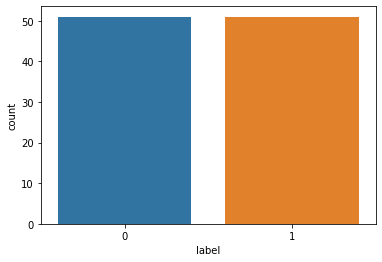

In [2]:
## --------------------------------------------------------
#                  Create the Dataframe
## --------------------------------------------------------
img_path = [] # store image paths for all images (all images are size 256x256)
label = [] # healthy (0) vs parkinsons (1)
dataset_folder = 'Spiral_DataSet1_relabelled'

# iterate through all of the images to create a binary array corresponding to the image labels
for labeled_folder in os.listdir(dataset_folder):
    for img in os.listdir(dataset_folder + "/" + labeled_folder):
        if labeled_folder == 'healthy':
            label.append(0)
        else:
            label.append(1)
        img_path.append(os.path.join(dataset_folder, labeled_folder, img))

# total number of images and labels should match
print(img_path[1], label[1])
print("total number of labels: ", len(label))
print("total number of images: ", len(img_path))

# now create the dataframe
df = pd.DataFrame()
df['images'] = img_path
df['label']  = label


df = df.sample(frac=1).reset_index(drop=True) # randomize the images, rather than having them be in order
df = utils.shuffle(df)

print(df)

# show the total count for each of the labels
sns.countplot(df['label'])
plt.show()

In [32]:
## -----------------------------------------------------------
#               Split into test and training data
## -----------------------------------------------------------
#randomly split data in train and test subsets
x_feature, val_feature, x_label, val_label = train_test_split(df['images'], df['label'], test_size=0.31, stratify=df['label'])

# shuffle data
#x_feature, x_label = utils.shuffle(x_feature, x_label)
val_feature, val_label = utils.shuffle(val_feature, val_label)

## (OPTIONAL) split val and test data
val_feature, test_feature, val_label, test_label = train_test_split(val_feature, val_label, test_size=0.5, shuffle=False)

print("# validation samples: ", len(val_label))
print("# testing samples: ", len(test_label))
print('# training samples: ', len(x_label))

print("pause")
# convert y-col to str for binary class_mode
# train['label'] = train['label'].astype('str')
# test['label']  = test['label'].astype('str')

# validation samples:  16
# testing samples:  16
# training samples:  70
pause


In [33]:
print(val_label)

76    0
30    0
97    1
21    1
15    1
64    1
22    0
72    0
9     0
41    0
14    0
93    1
69    1
86    1
60    1
57    0
Name: label, dtype: int64


In [34]:
## ------------------------------------------
#       Convert images to raw pixels
## ------------------------------------------
train_array = []
val_array = []

for img_path in x_feature:
    openImg = PIL.Image.open(img_path)
    image = openImg.convert("P") # covert to grayscale
    imgArray = np.array(image)
    imgArray = cv2.resize(imgArray, (128,128))
    imgArray = np.expand_dims(imgArray, axis=2)

    # store in array
    train_array.append(imgArray)

for img_path in val_feature:
    openImg = PIL.Image.open(img_path)
    image = openImg.convert("L") # covert to grayscale
    imgArray = np.array(image)
    imgArray = cv2.resize(imgArray, (128,128))
    imgArray = np.expand_dims(imgArray, axis=2)

    # store in array
    val_array.append(imgArray)


print("pause")


pause


In [35]:
## -------------------------------------------------------------------
#       Artificially create more images for a bigger dataset
## -------------------------------------------------------------------
# normalize the data
train_gen = ImageDataGenerator(
    #rescale=1./255,
    rotation_range=360,
    fill_mode='nearest',
    brightness_range=[.4,1.4],
    vertical_flip = True,
    horizontal_flip = True
)

test_gen = ImageDataGenerator(
    #rescale=1./255,
    rotation_range=360,
    fill_mode='nearest',
    brightness_range=[.4,1.4],
    vertical_flip = True,
    horizontal_flip = True
)

## add more training images
trainAug = []
trainAugLabel = []

for (i,v) in enumerate(x_label):
    #print("i: ", i)
    #print("v: ", v)
    tempImg = np.expand_dims(train_array[i], axis=0)
    aug = train_gen.flow(tempImg, batch_size=1, shuffle=True)
    for addImages in range(80):
        augImg = next(aug)[0].astype('uint8')
        if np.size(augImg) == 128**2:
            trainAug.append(augImg)
            trainAugLabel.append(v)

## add more validation images
valAug = []
valAugLabel = []

for (i,v) in enumerate(val_label):
    #print("i: ", i)
    #print("v: ", v)
    tempImg = np.expand_dims(val_array[i], axis=0)
    aug = test_gen.flow(tempImg, batch_size=1)
    for addImages in range(40):
        augImg = next(aug)[0].astype('uint8')
        if np.size(augImg) == 128**2:
            valAug.append(augImg)
            valAugLabel.append(v)

print("pause")

trainAugLabel = tf.keras.utils.to_categorical(np.array(trainAugLabel))
valAugLabel = tf.keras.utils.to_categorical(np.array(valAugLabel))


print("pause")

# shuffle data
trainAug, trainAugLabel = utils.shuffle(trainAug, trainAugLabel)
valAug, valAugLabel = utils.shuffle(valAug, valAugLabel)



pause
pause


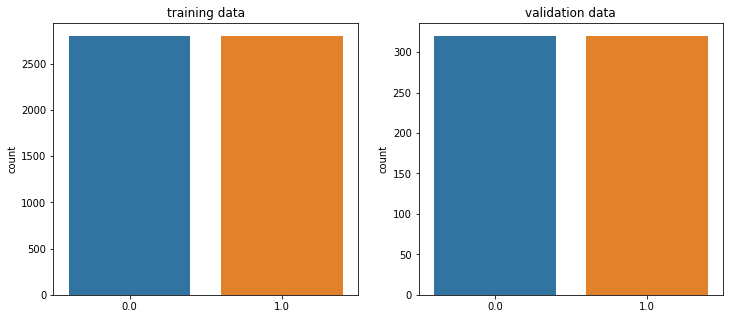

Total training data samples:  5600
Total validation data samples:  640
Training-to-validation ratio:  11.0 %


In [37]:
fig, ax = plt.subplots(1,2)
fig.set_size_inches(12,5)
ax0 = sns.countplot(trainAugLabel[:,1], ax=ax[0])
ax0.title.set_text("training data")
ax1 = sns.countplot(valAugLabel[:,1], ax=ax[1])
ax1.title.set_text("validation data")
plt.show()

print("Total training data samples: ", len(trainAug))
print("Total validation data samples: ", len(valAug))
print("Training-to-validation ratio: ", np.round(len(valAug)/len(trainAug),2)*100 , "%")

In [ ]:
# plot images
imgNum = 0 # insert number to view image
imfile = Image.fromarray(np.squeeze(val_array[4]))
imfile.show(imfile)   

In [ ]:
reg = tf.keras.regularizers.l2(0.001)
opt = tf.keras.optimizers.Adam(learning_rate=1e-3)

model = Sequential([
    Conv2D(32, (5,5), padding='same', strides=(1,1), dilation_rate = 1, activation='relu', kernel_regularizer=reg, input_shape=(128,128,1)),
    MaxPool2D((7,7), strides=(2,2)),
    Conv2D(32, (5,5), padding='same', strides=(1,1), dilation_rate = 2, activation='relu', kernel_regularizer=reg),
    MaxPool2D((5,5), strides=(2,2)),
    Conv2D(64, (3,3), padding='same', strides=(1,1), dilation_rate = 1, activation='relu', kernel_regularizer=reg),
    MaxPool2D((3,3), strides=(1,1)),
    Conv2D(128, (3,3), padding='same', strides=(1,1), dilation_rate = 2, activation='relu', kernel_regularizer=reg),
    MaxPool2D((3,3), strides=(1,1)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(2,activation='softmax')
])

model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

## Train the model
trained_model = model.fit(np.array(trainAug), np.array(trainAugLabel), batch_size=128, epochs=20, validation_data=(np.array(valAug), np.array(valAugLabel)))

In [ ]:
## -----------------------------------------------------------
#                       Plot the Results
## -----------------------------------------------------------
# Accuracy and Validation Accuracy
accuracy = trained_model.history['accuracy']
val_acc = trained_model.history['val_accuracy']
epochs = range(len(accuracy))

plt.plot(epochs, accuracy, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.grid()
plt.figure()

# Loss and Validation Loss
loss = trained_model.history['loss']
val_loss = trained_model.history['val_loss']

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()
plt.grid()
plt.show()

In [ ]:

model = Sequential()
model.add(Conv2D(32, (5,5), padding='same', strides=(1,1), dilation_rate = 1, activation=tf.keras.activations.LeakyReLU(alpha=0.1), kernel_regularizer=reg, input_shape=(128,128,1)))
model.add(MaxPool2D((7,7), strides=(2,2)))
model.add(Conv2D(64, (5,5), padding='same', strides=(1,1), dilation_rate = 1, activation=tf.keras.activations.LeakyReLU(alpha=0.1), kernel_regularizer=reg))
model.add(MaxPool2D((3,3), strides=(2,2)))
model.add(Conv2D(128, (3,3), padding='same', strides=(1,1), dilation_rate = 1, activation='relu', kernel_regularizer=reg))
model.add(MaxPool2D((3,3), strides=(1,1)))
model.add(Conv2D(256, (3,3), padding='same', strides=(1,1), dilation_rate = 2, activation='relu', kernel_regularizer=reg))
model.add(MaxPool2D((3,3), strides=(1,1)))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(2,activation='softmax'))


### Archive Models

In [ ]:
## -----------------------------------------------------------
#                       Build the Model
## -----------------------------------------------------------

model = Sequential([
    Conv2D(16, (3,3), activation='relu', input_shape=(256,256,1)),
    MaxPool2D((2,2)),
    Conv2D(32, (3,3), activation='relu'),
    MaxPool2D((2,2)),
    Conv2D(32, (3,3), activation='relu'),
    MaxPool2D((2,2)),
    Dropout(0.1),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(1,activation='sigmoid')
])

'''
model = Sequential([
    Conv2D(16, (3,3), activation='relu', input_shape=(128,128,3)),
    MaxPool2D((2,2)),
    Dropout(0.25),
    Conv2D(32, (3,3), activation='relu'),
    MaxPool2D((2,2)),
    Dropout(0.4),
    Conv2D(64, (3,3), activation='relu'),
    MaxPool2D((2,2)),
    Dropout(0.4),
    Conv2D(64, (3,3), activation='relu'),
    MaxPool2D((2,2)),
    Dropout(0.4),
    Conv2D(64, (3,3), activation='relu'),
    MaxPool2D((2,2)),
    Dropout(0.4),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.3),
    Dense(1,activation='sigmoid')
])


model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(128,128,1)),
    MaxPool2D((2,2)),
    Dropout(0.25),
    Conv2D(64, (3,3), activation='relu'),
    MaxPool2D((2,2)),
    Dropout(0.4),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.3),
    Dense(1,activation='sigmoid')
])
'''


model = Sequential([
    Conv2D(32, (5,5), padding='same', strides=(1,1), dilation_rate = 1, activation='relu', kernel_regularizer=reg, input_shape=(128,128,1)),
    MaxPool2D((7,7), strides=(2,2)),
    Conv2D(64, (5,5), padding='same', strides=(1,1), dilation_rate = 1, activation='relu', kernel_regularizer=reg),
    MaxPool2D((3,3), strides=(2,2)),
    Conv2D(128, (3,3), padding='same', strides=(1,1), dilation_rate = 1, activation='relu', kernel_regularizer=reg),
    MaxPool2D((3,3), strides=(1,1)),
    Conv2D(256, (3,3), padding='same', strides=(1,1), dilation_rate = 2, activation='relu', kernel_regularizer=reg),
    MaxPool2D((3,3), strides=(1,1)),
    Flatten(),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(2,activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

## Train the model
trained_model = model.fit(np.array(trainAug), trainAugLabel, epochs=50, validation_data=(np.array(testAug), testAugLabel))

In [7]:
newModel = tf.keras.models.load_model("h5model.h5")

newModel.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1 (Conv2D)              (None, 128, 128, 128)     3328      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 40, 40, 128)      0         
 )                                                               
                                                                 
 conv2 (Conv2D)              (None, 40, 40, 64)        204864    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 12, 64)       0         
 2D)                                                             
                                                                 
 conv3 (Conv2D)              (None, 12, 12, 32)        18464     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 4, 4, 32)         0

In [36]:
loss, acc = newModel.evaluate(np.array(valAug), valAugLabel, verbose=2)
print(acc)

20/20 - 7s - loss: 96.9120 - accuracy: 0.7766 - 7s/epoch - 357ms/step
0.776562511920929


In [ ]:
np.shape(val_array)